In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import torchvision
import matplotlib.pyplot as plt
import numpy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 64 * 7 * 7), 
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1), 
            nn.Tanh() 
        )

    def forward(self, z):
        img = self.model(z)
        return img


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1), 
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [16]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [17]:

noise_dim = 100
learning_rate = 0.0002
num_epochs = 50

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [18]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_G.zero_grad()

        # predict
        z = torch.randn(imgs.size(0), noise_dim).to(device)
        generated_imgs = generator(z)

        # loss gen
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        # loss disc
        real_loss = adversarial_loss(discriminator(imgs.to(device)), real_labels)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # backward
        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f}")


Epoch [1/50] Batch 0/938                   Loss D: 0.6570, Loss G: 0.6793
Epoch [1/50] Batch 100/938                   Loss D: 0.0893, Loss G: 2.8258
Epoch [1/50] Batch 200/938                   Loss D: 0.2703, Loss G: 1.4291
Epoch [1/50] Batch 300/938                   Loss D: 0.2885, Loss G: 1.1041
Epoch [1/50] Batch 400/938                   Loss D: 0.1794, Loss G: 1.7499
Epoch [1/50] Batch 500/938                   Loss D: 0.1761, Loss G: 2.4063
Epoch [1/50] Batch 600/938                   Loss D: 0.1133, Loss G: 2.1685
Epoch [1/50] Batch 700/938                   Loss D: 0.0772, Loss G: 2.6192
Epoch [1/50] Batch 800/938                   Loss D: 0.0946, Loss G: 2.5372
Epoch [1/50] Batch 900/938                   Loss D: 0.0822, Loss G: 2.5509
Epoch [2/50] Batch 0/938                   Loss D: 0.1170, Loss G: 2.6001
Epoch [2/50] Batch 100/938                   Loss D: 0.0920, Loss G: 3.7674
Epoch [2/50] Batch 200/938                   Loss D: 0.1175, Loss G: 2.3262
Epoch [2/50] Bat

In [20]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


In [21]:
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

C:\Users\parth\AppData\Local\Temp\ipykernel_9796\1611587311.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
C:\Use

<All keys matched successfully>

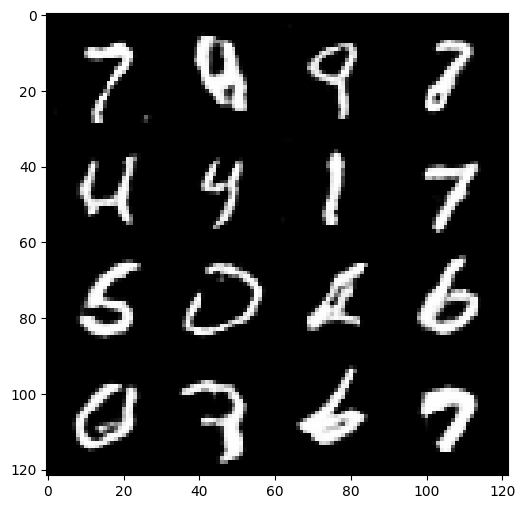

In [22]:
# create images
noise = torch.randn(16, noise_dim).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
grid = make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()